![meme](https://i.imgflip.com/6x0g1f.jpg)

# Optimizing fantasy basketball

Fantasy basketball is an extremely popular pasttime for nba fans. Participants 'draft' players before the season, then get rewarded for their proxy's in-game performances during the season. 

One popular format is 'Head-to-Head: Most Categories'. Quoting from ESPN's description of the rules:

>Head-to-Head: Most Categories: H2H Most Categories allows you to set "X" number of statistic categories. For each scoring period (usually Monday through Sunday) team totals are accumulated in each of the categories. At the end of the scoring period, the winner is determined by which team wins the most number of categories. The end result is a win (1-0-0), loss (0-1-0) or tie (0-0-1). These results correspond directly to each team's overall record.

Common settings specify 9 categories: points, rebounds, assists, steals, blocks, 3-pointers, field goal %, free throw %, and turnovers. 

Participants are paired up to compete week-by-week, and at the end of the season, the player with the best record wins.

Understanding the game of basketball helps win fantasy drafts. However, it's not the whole ballgame: even if we had precise probability distributions for player performance beforehand, or exact numbers with no uncertainty, it would not be obvious how to draft correctly. Do we want to optimize for all 9 categories, or just some of them? Do we try to compete on the categories that other drafters are going for, or ones they are not? Do we embrace high-volatility players or low-volatility players? The problem becomes a rich mathematical one, more familiar to data scientists than to basketball enthusiasts

There is plenty of speculation about all this within the fantasy basketball community. However, few in the community realize that their strategies are leveraging high-level mathematical intuition. If we lean into the math, and treat this as an optimization problem, can we derive a method for fantasy drafting that delivers consistently high performance?

Our approach will be to break down the drafting problem into three mathematical steps
- Retrospectively drafting a full previous season, with full knowledge of player performance. Weekly totals will be randomly sampled from actual weekly totals for each player. Fantasy drafting this way becomes a full-information game, and therefore at least one Nash equilibrium exists. We will explore different ways of looking for it 
- Incorporating uncertainty into the priors of restrospective-drafting. We will explore how the strategy for retrospective drafting changes when there is uncertainty about the underlying probability distributions of player statistics
- Using predictive data science methods to make estimates of priors/posteriors for actual performance. This last step will allow us to design an actual drafting algorithm that could be used for a season of fantasy basketball

# Retrospective drafting

In [65]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from itertools import combinations
from collections import Counter
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

pd.options.mode.chained_assignment = None  # default='warn'

We will use the raw data from [link](https://www.advancedsportsanalytics.com/nba-raw-data)

In [2]:
stat_df = pd.read_csv('../data/ASA All NBA Raw Data.csv')
essential_info = stat_df[['player','game_date','pts','trb','ast','stl','blk','fg3','fg','fga','ft','fta','tov']]

In [3]:
player_totals = essential_info.drop(columns= 'game_date').groupby(['player']).sum()
player_totals.loc[:,'ft_pct'] = player_totals['ft']/player_totals['fta']
player_totals.loc[:,'fg_pct'] = player_totals['fg']/player_totals['fga']
player_totals = player_totals.drop(columns = ['ft','fta','fg','fga'])

In [37]:
#defining round robin opponents, based on the circle method 
def round_robin_opponent(t
                         , w
                         , n =12): # n must be an even number
    
    if t == 0: #position 0 remains fixed, and the other teams rotate around their (n - 1) spots
        return ((n - 2 - w) % (n - 1) ) + 1
    elif ((t + w) % 11 ==0): # in spot (n-1) of the non-zero spots, the opponent is 0 
        return 0 
    else: #we calculate the current position of team, infer the opponent's position, then calculate the opposing team
        res = (((n - 1 - (t + w) % (n - 1)) % (n - 1))- w) % (n - 1)
        return (n - 1) if res == 0 else res
         
#this is based on the circle method 

In [166]:
def run_multiple_seasons(teams, n = 100):
    #returns the winner
    season_df = essential_info.drop(columns = 'game_date')
    season_df.loc[:,'team'] = season_df['player'].map(teams) 
    season_df = season_df.dropna()

    performances = season_df.groupby('player').sample(11*n, replace = True)
    performances.loc[:,'week'] = performances.groupby('player').cumcount()
    performances.loc[:,'season'] = performances['week'] // 11

    team_performances = performances.groupby(['season','team','week']).sum()
    team_performances.loc[:,'fg_pct'] = np.where(team_performances['fga'] > 0
                                             ,team_performances['fg']/team_performances['fga']
                                             ,0)
    team_performances.loc[:,'ft_pct'] = np.where(team_performances['fta'] > 0
                                             ,team_performances['ft']/team_performances['fta']
                                             ,0)
    team_performances['tov'] = - team_performances['tov'] #the logic is reversed for turnovers
    team_performances = team_performances.drop(columns = ['fg','fga','ft','fta'])
    opposing_team_schedule = [(s,round_robin_opponent(t,w),w) for s, t, w in team_performances.index]
    opposing_team_performances = team_performances.loc[opposing_team_schedule]

    cat_losses = np.less(team_performances.values,opposing_team_performances.values).sum(axis = 1)
    cat_wins = np.greater(team_performances.values,opposing_team_performances.values).sum(axis = 1)

    team_performances.loc[:,'tie'] = cat_wins == cat_losses
    team_performances.loc[:,'win'] = cat_wins > cat_losses
    team_results = team_performances.groupby(['team','season']).agg({'win' : sum, 'tie' : sum})

    most_wins = team_results.groupby('season')['win'].transform('max')
    winners = team_results[team_results['win'] == most_wins]

    most_ties = winners.groupby('season')['tie'].transform('max')
    winners_after_ties = winners[winners['tie'] == most_ties]
    winners_after_ties.loc[:,'winner_points'] = 1
    season_counts = winners_after_ties.groupby('season')['winner_points'].transform('count')
    winners_after_ties.loc[:,'winner_points_adjusted'] = 1/season_counts
    return winners_after_ties.groupby('team')['winner_points_adjusted'].sum()

In [194]:
class simple_agent():
    
    def __init__(self, punting_cats =[], scaler = StandardScaler()):
        
        player_totals_scaled = pd.DataFrame(scaler.fit_transform(player_totals)
                                            , index = player_totals.index
                                            ,columns = player_totals.columns)
        player_totals_scaled['tov'] = - player_totals_scaled['tov']
        
        self.order = player_totals_scaled.drop(columns = punting_cats).sum(axis = 1).sort_values(ascending = False)

    def make_pick(self, player_assignments):
        f = pd.Series(~self.order.index.isin(player_assignments.keys()), index = self.order.index)
        chosen_player = next(i for i,v in f.iteritems() if v)
        return chosen_player
    
class random_agent():
    
    def __init__(self, punting_cats):
        self.order = player_totals_scaled.shuffle()

    def make_pick(self, player_assignments):
        f = pd.Series(~self.order.index.isin(player_assignments.keys()), index = self.order.index)
        chosen_player = next(i for i,v in f.iteritems() if v)
        return chosen_player


In [195]:
def run_draft(agents, number_of_rounds):
    
    player_assignments = {}
    
    for i in range(number_of_rounds):
        for j in range(len(agents)):
            
            agent = agents[j]
            chosen_player = agent.make_pick(player_assignments)
            player_assignments[chosen_player] = j
            
        for j in reversed(range(len(agents))):
            agent = agents[j]
            chosen_player = agent.make_pick(player_assignments)
            player_assignments[chosen_player] = j

    return player_assignments

In [196]:
def try_strategy(primary_agent, default_agent, n_seasons):

    strategy_res = [[] for i in range(12)]
    players = [] #keep track of all players selected by the primary agent
    for i in range(12):
        agents = [default_agent]* i + [primary_agent] + [default_agent]*(11 - i)
        teams = run_draft(agents ,3)
        players = players + [k for k,v in teams.items() if v == i]
        res = run_multiple_seasons(teams, n_seasons)
        strategy_res[i] = (res.get(i)) if (res.get(i)) is not None else 0 
    return np.sum(strategy_res)/(12*n_seasons) #, players


## 1a. Scaling Strategy

In [200]:
agents = {'standard' : simple_agent(scaler = StandardScaler())
        , 'quantile' :  simple_agent(scaler = QuantileTransformer(n_quantiles = 621))
        , 'minmax' : simple_agent(scaler = MinMaxScaler())
         }

start = datetime.now()
combinatorial_results = pd.DataFrame(index = agents.keys(), columns = agents.keys())
for primary_agent_name in agents.keys():
    for default_agent_name in agents.keys():
        if primary_agent_name != default_agent_name:
            combinatorial_results.loc[primary_agent_name,default_agent_name] = try_strategy(
                                                                        agents[primary_agent_name]
                                                                        ,agents[default_agent_name]
                                                                        ,500)
print(datetime.now() - start)
combinatorial_results

0:00:39.621813


,standard,quantile,minmax
standard,NaN,0.102172,0.008704
quantile,0.046631,NaN,0.137069
minmax,0.029708,0.397033,NaN


Interestingly, no single option seems to be the best. StandardScaler() is generally quite good, but it struggles when it is the only StandardScaler() drafter and everybody else is using MinMaxScaler()



## 1b. Punting Strategy

In [190]:
def try_punting_strategy(punting_cats, n = 500):
    primary_agent = simple_agent(punting_cats = punting_cats, scaler = StandardScaler())
    default_agent = simple_agent(punting_cats = [], scaler = StandardScaler())
    res = try_strategy(primary_agent, default_agent, n)
    variance = np.sqrt(res*(1-res)/(12 * n))
    return res, variance

In [191]:
start = datetime.now()
results = {cat : try_punting_strategy([cat]) for cat in player_totals.columns}
print(datetime.now() - start)

0:01:04.825371


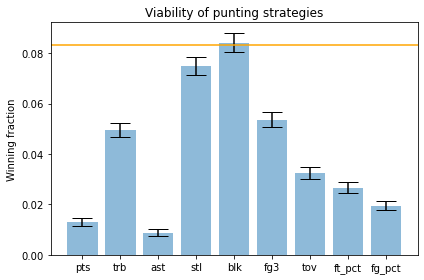

In [192]:
results_unpacked = list(map(list,zip(*[(x[0],x[1][0],x[1][1]) for x in results.items()])))

fig, ax = plt.subplots()

x_pos = np.arange(len(results_unpacked[0]))
ax.bar(x_pos
       , results_unpacked[1]
       , yerr=results_unpacked[2]
       , align='center'
       , alpha=0.5
       , ecolor='black'
       , capsize=10)

ax.set_ylabel('Winning fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_unpacked[0])
ax.set_title('Viability of punting strategies')
ax.axhline(y=1/12, color='orange', linestyle='-')

# Save the figure and show
plt.tight_layout()
plt.show()